# MORO playground

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator, 
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import (perform_experiments, optimize,
                                                   BaseEvaluator)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline

ema_logging.log_to_stderr(ema_logging.INFO)

BaseEvaluator.reporting_frequency = 0.01

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
dike_model, planning_steps = get_model_for_problem_formulation(1) # assign problem_formulation_id

## Robustness metrics

In [3]:
def percentile90(damage):
    return np.percentile(damage, q=90)/1e9 #in billion

def raw_costs_billion(investment):
    return investment.max()/1e9 #raw values in billion

def nrdeath_filter(deaths):
    nrdeath = deaths.max() if deaths.max() < 1 else 1
    return nrdeath

In [4]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE 

robustness_functions = [ScalarOutcome('Expected Annual Damage', kind=MINIMIZE,
                             variable_name='Expected Annual Damage', function = percentile90),
                        ScalarOutcome('Total Investment Costs', kind=MINIMIZE,
                             variable_name='Total Investment Costs', function = raw_costs_billion),
                        ScalarOutcome('Expected Number of Deaths', kind=MINIMIZE,
                             variable_name='Expected Number of Deaths', function = nrdeath_filter)]

## Define number of scenarios

From the graph we can see that robustness metric for deaths converges at around 500 scenarios. However, as we are minimizing this metric, we are more interested in the policies whose metric scores are < 0.5. In this case, 200 scenarios are enough for robustness optimization.

In [5]:
# load results nr scenarios= 1000, nr policies = 10 using lhs sampling
results = load_results('./results/open_exploration_uncertainties_10000runs.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_10000runs.tar.gz


Text(0.5, 0, '# experiments')

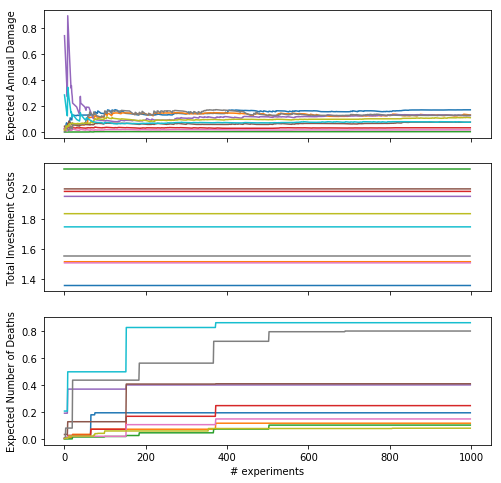

In [6]:
funcs = {'Expected Annual Damage': percentile90,
         'Total Investment Costs': raw_costs_billion,
         'Expected Number of Deaths': nrdeath_filter}

fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(8,8), sharex=True)
axes = [axes[0], axes[1], axes[2]]

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_ylabel(outcome)
ax.set_xlabel("# experiments")

## parcoods

Here we demonstrate the transformation of outcomes to robustness metrics using the pre-loaded results.

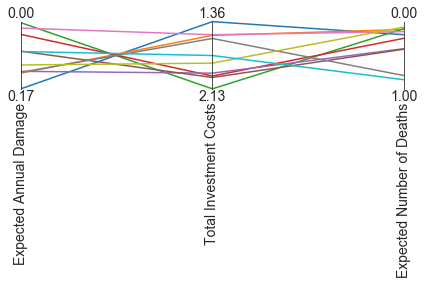

In [7]:
# calculate robustness metrics
outcomes_lever = pd.merge(pd.DataFrame.from_dict(outcomes), experiments.policy,
                         left_index=True, right_index=True)
robustness = []
for lever in outcomes_lever.policy.unique(): # per lever
    o = outcomes_lever.loc[outcomes_lever.policy == lever]
    metrics = [funcs[key](o[key]) for key in outcomes]
    robustness += [metrics]
robustness = pd.DataFrame(robustness, columns=outcomes.keys())

# plot parcoords
limits = parcoords.get_limits(robustness)
limits.loc[0, ['Expected Annual Damage', 'Expected Number of Deaths']] = 0 # set lower limits for damage and deaths to 0
limits.loc[1, 'Expected Number of Deaths'] = 1 # set upper limits for deaths to 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(robustness)

# invert axis so direction of desirability is at the top
paraxes.invert_axis('Expected Annual Damage')
paraxes.invert_axis('Total Investment Costs')
paraxes.invert_axis('Expected Number of Deaths')
plt.show()

## Robust optimize

Run robust optimization for 200 sampled scenarios and 500 nfe with epsilons of:

- Epsilon for the 90th percentile of *Expected Annual Damage* ~ 0.2 billion
- Epsilon for *Total Investment Costs* ~ 0.2 billion
- Epsilon for *Expected Number of Deaths*: ~ 0.1 person

In [8]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 200
ref_scenarios = sample_uncertainties(dike_model, n_scenarios)

In [9]:
nfe = 500

epsilon = [0.2, 0.2, 0.1]

convergence_metrics = [HyperVolume(minimum=[0,0,0], maximum=[3, 3, 1.01]),
                       EpsilonProgress()]

In [ ]:
%%time

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.robust_optimize(robustness_functions, ref_scenarios,
                                        nfe=nfe, convergence=convergence_metrics, epsilons=epsilon,
                                        convergence_freq=100, logging_freq=1)
    
save_results(results, './results/robust_opt_500nfe_200scenario.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/500 nfe
[MainProcess/INFO] generation 1: 100/500 nfe
[MainProcess/INFO] generation 2: 200/500 nfe


The optimization finished (though the messages were missing) and 8 solutions are found.

In [18]:
results = load_results('./results/robust_opt_500nfe_200scenario.tar.gz')

experiments, convergence = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\robust_opt_500nfe_200scenario.tar.gz


Text(0.5, 0, 'number of function evaluations')

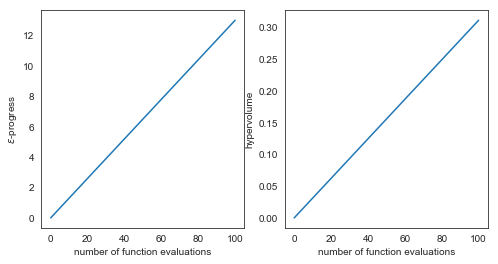

In [19]:
# check convergence (the workbench failed to save the convergence results)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

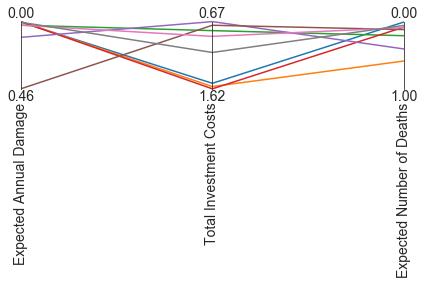

In [20]:
outcomes = experiments.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(outcomes)
limits.loc[0, ['Expected Annual Damage', 'Expected Number of Deaths']] = 0 # set lower limits for damage and deaths to 0
limits.loc[1, 'Expected Number of Deaths'] = 1 # set upper limits for deaths to 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(outcomes)

# invert axis so direction of desirability is at the top
paraxes.invert_axis('Expected Annual Damage')
paraxes.invert_axis('Total Investment Costs')
paraxes.invert_axis('Expected Number of Deaths')
plt.show()

In [35]:
experiments.T

,0,1,2,3,4,5,6,7
0_RfR 0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
0_RfR 1,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
0_RfR 2,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
1_RfR 0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1_RfR 1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1_RfR 2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2_RfR 0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2_RfR 1,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
2_RfR 2,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
3_RfR 0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000


In [34]:
# check the found solutions
levers = experiments.loc[:, [l.name for l in dike_model.levers]]
levers.T

,0,1,2,3,4,5,6,7
0_RfR 0,0,1,0,1,1,0,0,0
0_RfR 1,0,1,0,1,0,0,1,1
0_RfR 2,1,1,1,1,0,0,1,1
1_RfR 0,1,0,0,0,0,0,0,0
1_RfR 1,0,0,0,1,0,0,0,0
1_RfR 2,0,1,0,0,0,0,0,0
2_RfR 0,1,1,1,0,0,0,1,0
2_RfR 1,0,1,1,1,1,1,0,1
2_RfR 2,1,1,0,0,0,1,0,1
3_RfR 0,0,0,1,1,0,0,1,1
